In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for idx, filename in enumerate(filenames):
        print(os.path.join(dirname, filename))
        if idx == 5:
            break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/artist-data/sample_submission.csv
/kaggle/input/artist-data/artists_info.csv
/kaggle/input/artist-data/train.csv
/kaggle/input/artist-data/test.csv
/kaggle/input/artist-data/test/TEST_04038.jpg
/kaggle/input/artist-data/test/TEST_07075.jpg
/kaggle/input/artist-data/test/TEST_04342.jpg
/kaggle/input/artist-data/test/TEST_00733.jpg
/kaggle/input/artist-data/test/TEST_03764.jpg
/kaggle/input/artist-data/test/TEST_09250.jpg
/kaggle/input/artist-data/train/0664.jpg
/kaggle/input/artist-data/train/1269.jpg
/kaggle/input/artist-data/train/3863.jpg
/kaggle/input/artist-data/train/2193.jpg
/kaggle/input/artist-data/train/0733.jpg
/kaggle/input/artist-data/train/3750.jpg


In [2]:
!pip install timm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

import cv2
from PIL import Image

import matplotlib.pyplot as plt

import timm
import math
import time
import copy
import random
from collections import Counter

from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
!nvidia-smi

Thu Nov 24 08:50:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [5]:
# set up gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [32]:
# hyperparameters
IMG_SIZE = 480
EPOCHS = 100
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
SEED = 41

In [33]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED) 

In [34]:
# read CSV
train_df = pd.read_csv("/kaggle/input/artist-data/train.csv")
test_df = pd.read_csv("/kaggle/input/artist-data/test.csv")

In [35]:
print(train_df[train_df.index == 3896])
print(train_df[train_df.index == 3986])

        id          img_path       artist
3896  3896  ./train/3896.jpg  Edgar Degas
        id          img_path  artist
3986  3896  ./train/3896.jpg  Titian


In [36]:
# fix the typos
train_df.iloc[3896, 2] = "Titian"
train_df.iloc[3986, 2] = "Alfred Sisley"
train_df.iloc[3986, 1] = r"./train/3986.jpg"

In [37]:
print(train_df[train_df.index == 3896])
print(train_df[train_df.index == 3986])

        id          img_path  artist
3896  3896  ./train/3896.jpg  Titian
        id          img_path         artist
3986  3896  ./train/3986.jpg  Alfred Sisley


In [38]:
# edit paths
train_df['img_path'] = train_df['img_path'].apply(lambda x: x.replace(".", r"/kaggle/input/artist-data/", 1))
test_df['img_path'] = test_df['img_path'].apply(lambda x: x.replace(".", r"/kaggle/input/artist-data/", 1))

In [39]:
# Labeling
le = preprocessing.LabelEncoder()
train_df['label'] = le.fit_transform(train_df['artist'].values)

In [40]:
# count # of unique artists
print("length of train data:", len(train_df))
print("unique:", len(train_df['label'].unique()))

length of train data: 5911
unique: 50


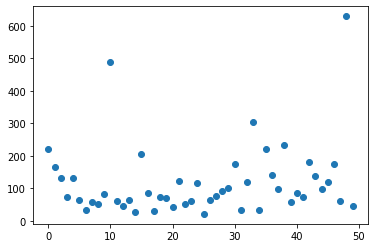

In [41]:
# visualize label distribution
cnt = Counter(train_df['label'].values)
plt.scatter(cnt.keys(), cnt.values())
plt.show()

# Imbalanced label distribution

In [42]:
train_df, val_df, _, _ = train_test_split(train_df, train_df['label'].values, test_size=0.1, random_state=SEED)

In [43]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist,label
0,0,/kaggle/input/artist-data//train/0000.jpg,Diego Velazquez,9
1,1,/kaggle/input/artist-data//train/0001.jpg,Vincent van Gogh,48
2,2,/kaggle/input/artist-data//train/0002.jpg,Claude Monet,7
3,3,/kaggle/input/artist-data//train/0003.jpg,Edgar Degas,10
5,5,/kaggle/input/artist-data//train/0005.jpg,Pierre-Auguste Renoir,38


In [44]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist,label
4,4,/kaggle/input/artist-data//train/0004.jpg,Hieronymus Bosch,24
17,17,/kaggle/input/artist-data//train/0017.jpg,Edgar Degas,10
21,21,/kaggle/input/artist-data//train/0021.jpg,Leonardo da Vinci,29
29,29,/kaggle/input/artist-data//train/0029.jpg,Kazimir Malevich,28
37,37,/kaggle/input/artist-data//train/0037.jpg,Pablo Picasso,33


In [45]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].values
    return df['img_path'].values, df['label'].values

train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

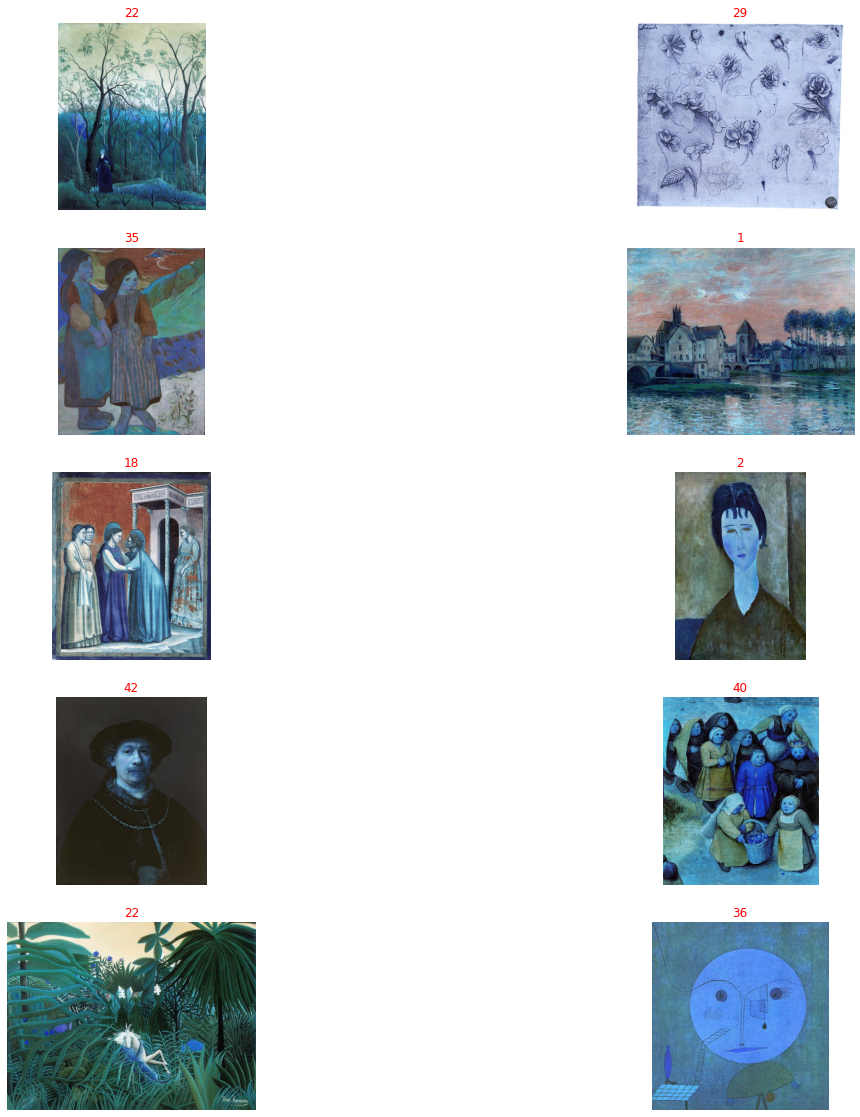

In [46]:
# show images

def display_image(images_filepaths, labels, cols=5):
    
    length = len(images_filepaths)
    rand_idx = torch.randperm(length)[:10]

    figure, ax = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
    
    for i, image_filepath in enumerate(images_filepaths[rand_idx]):
        image = cv2.imread(image_filepath)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(labels[rand_idx[i]],color='red')
        ax.ravel()[i].set_axis_off()

    #plt.tight_layout()
    plt.show()

display_image(train_img_paths, train_labels)

In [47]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_paths)

In [48]:
train_labels

array([ 9, 48,  7, ..., 35, 35,  3])

In [49]:
train_transform = A.Compose([
                            A.RandomResizedCrop(
                            height=IMG_SIZE, 
                            width=IMG_SIZE, 
                            scale=(0.24, 0.26),
                            ratio=(0.90, 1.10),
                            always_apply=True),
                            A.HorizontalFlip(p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(IMG_SIZE,IMG_SIZE),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [50]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size =BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_img_paths, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [51]:
train_dataset[0][0][1].dtype

torch.float32

In [52]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.efficientnet = timm.create_model('tf_efficientnetv2_m', pretrained=True, num_classes=num_classes)
        
    def forward(self, x):
        
        return self.efficientnet(x)

In [53]:
def train(model, optimizer, train_loader, test_loader, scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    patience = 10
    tr_losses = []
    val_losses = []
    
    for epoch in range(1,EPOCHS+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)
            optimizer.zero_grad()

            model_pred = model(img)
            
            loss = criterion(model_pred, label)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)
            
        val_loss, val_score = validation(model, criterion, test_loader, device)
           
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        
        tr_losses.append(tr_loss)
        val_losses.append(val_loss)

        scheduler.step()
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
            counter=0
        else:
            counter+=1
                
        if counter > patience:
            print("Early Stopping...")
            break
        
    return best_model, tr_losses, val_losses

In [54]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.to(device)
            
            model_pred = model(img)
            
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
        
    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [55]:
### LR scheduler (SGDR)
# Custom Cosine Annealing Warmup Restart
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [56]:
model = BaseModel()
model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1])

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)
#scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.001,  T_up=3, gamma=0.5)

# infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)
criterion = nn.CrossEntropyLoss().to(device)

best_score = 0
best_model = None
patience = 10
tr_losses = []
val_losses = []

In [ ]:
for epoch in range(1,EPOCHS+1):

    train_loss = []
    for img, label in tqdm(iter(train_loader)):
        img, label = img.float().to(device), label.to(device)
        optimizer.zero_grad()

        model_pred = model(img)

        loss = criterion(model_pred, label)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    tr_loss = np.mean(train_loss)

    val_loss, val_score = validation(model, criterion, val_loader, device)

    print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')

    tr_losses.append(tr_loss)
    val_losses.append(val_loss)

    #scheduler.step()

    if best_score < val_score:
        best_model = model
        best_score = val_score
        counter=0
    else:
        counter+=1

    if counter > patience:
        print("Early Stopping...")
        break

    # save model

torch.save(infer_model, f'./model.pt')

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [1], Train Loss : [2.03679] Val Loss : [1.56254] Val F1 Score : [0.41727]


  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.24131] Val Loss : [1.68386] Val F1 Score : [0.37382]


  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.71284] Val Loss : [1.32026] Val F1 Score : [0.51577]


  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.51008] Val Loss : [1.65083] Val F1 Score : [0.49340]


  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.38457] Val Loss : [1.64643] Val F1 Score : [0.49993]


  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.32706] Val Loss : [1.63391] Val F1 Score : [0.53054]


  0%|          | 0/333 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# load model
model = torch.load("model.pt", map_location=device)

In [ ]:
test_img_paths = get_data(test_df, infer=True)
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    
    model.to(device)
    model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)
            
            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
    
    print('Done.')
    return model_preds

In [ ]:
# Inference
preds = inference(model[0], test_loader, device)

In [ ]:
# Submission
preds = le.inverse_transform(preds)
submit = pd.read_csv('/kaggle/input/artist-data/sample_submission.csv')
submit['artist'] = preds
submit.to_csv('./submit.csv', index=False)

In [ ]:
model[0]